In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mc
from itertools import combinations
from scipy.spatial import cKDTree
from IPython.display import display


DATA_PATH = "/home/kartik/layout-analysis/stress-test-data"
SAMPLE_SIZE = 6  #number of pages to process




In [2]:

NUM_NEIGHBOURS = 8
norm_ratio_threshold = 2  # Allows a max ratio of 1.5 between the norms
cos_similarity_less_than = -0.8
# we assume that character spacing is less than line spacing 
distance_then_angle = False

%matplotlib widget


Processing file: /home/kartik/layout-analysis/stress-test-data/pg_0_points.txt


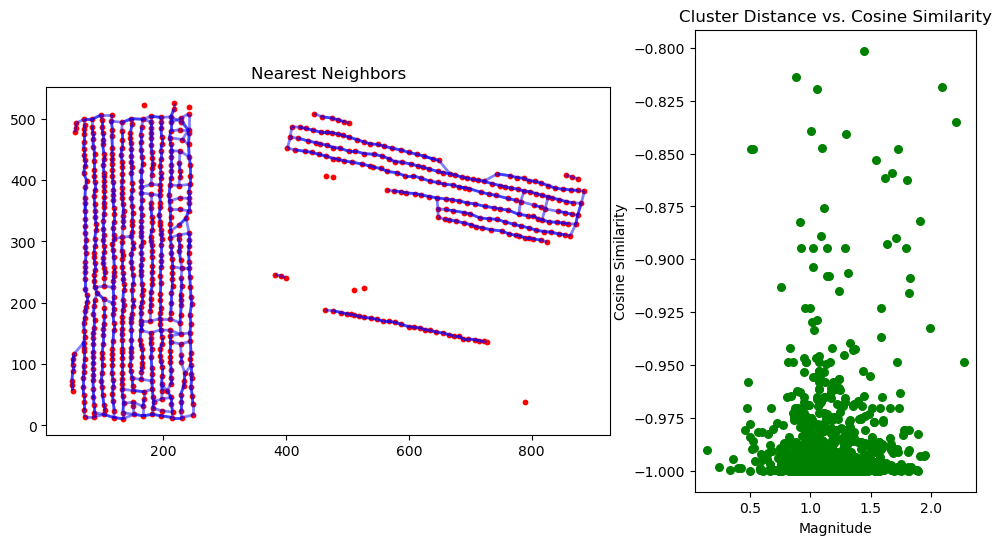

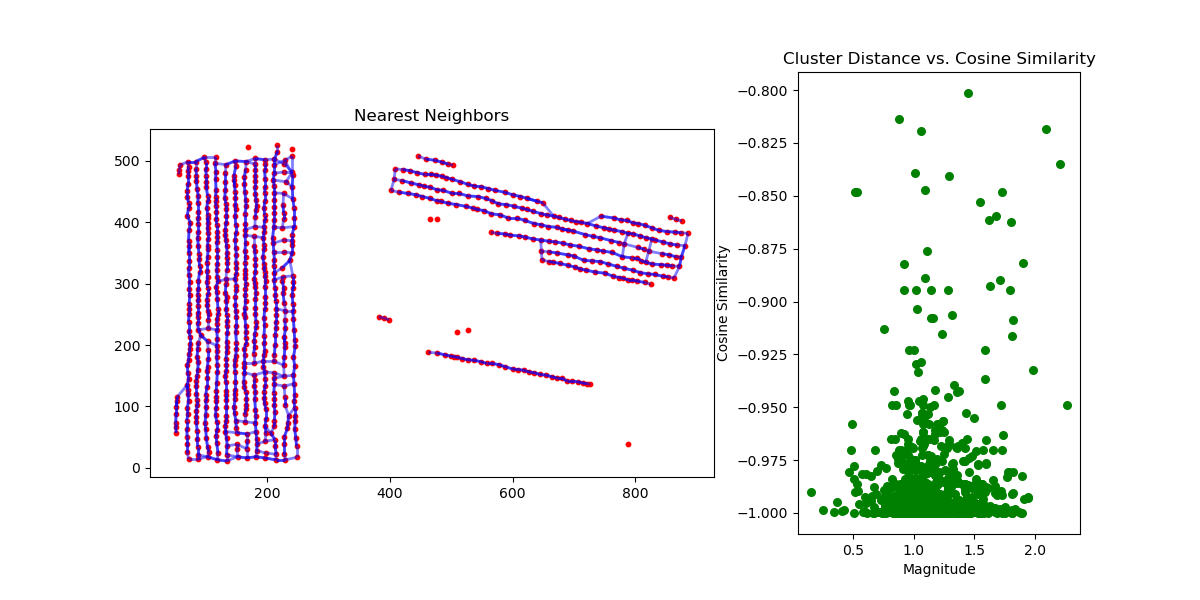

In [ ]:
# Get unique prefixes efficiently without sorting everything
for entry in os.scandir(DATA_PATH):
    if entry.is_file() and entry.name.endswith('pg_0_points.txt'):
        points_file = entry.path
        print(f"Processing file: {points_file}")
        points = np.loadtxt(points_file)
        
        # Build a KD-tree for fast neighbor lookup
        tree = cKDTree(points)
        _, indices = tree.query(points, k=NUM_NEIGHBOURS)
        
        segments = [] 
        to_cluster = []
        to_plot = []

        # Process nearest neighbors
        for current_point_index, nbr_indices in enumerate(indices):
            normalized_points = points[nbr_indices] - points[current_point_index]
            scaling_factor = np.max(np.abs(normalized_points))
            if scaling_factor == 0:
                scaling_factor = 1
            scaled_points = normalized_points / scaling_factor
            relative_neighbours = [(global_idx, sp)
                                   for global_idx, sp in zip(nbr_indices, scaled_points)]
            
            filtered_neighbours = []
            for _a, _b in combinations(relative_neighbours, 2):
                relative_vector1 = _a[1]
                relative_vector2 = _b[1]
                norm1 = np.linalg.norm(relative_vector1)
                norm2 = np.linalg.norm(relative_vector2)
                if norm1 * norm2 == 0:
                    cos_similarity = 0.0
                else:
                    cos_similarity = np.dot(relative_vector1, relative_vector2) / (norm1 * norm2)
                
                if (cos_similarity < cos_similarity_less_than and 
                    (1 / norm_ratio_threshold) <= (norm1 / norm2) <= norm_ratio_threshold):
                    total_distance = norm1 + norm2
                    filtered_neighbours.append((_a, _b, total_distance, cos_similarity))
            
            if filtered_neighbours:
                shortest_pair = min(filtered_neighbours, key=lambda x: x[2])
                _connection_1, _connection_2, distance, cos_similarity = shortest_pair
                global_idx_connection_1 = _connection_1[0]
                global_idx_connection_2 = _connection_2[0]
                
                to_plot.append((current_point_index, global_idx_connection_1, global_idx_connection_2))
                to_cluster.append((distance, cos_similarity))
        
        # Adjust figure layout: large left panel for nearest neighbors, smaller right panel for scatter plot
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), 
                                       gridspec_kw={'width_ratios': [2, 1]})  # Left panel is twice the width
        
        # Nearest neighbors plot (left)
        for s in to_plot:
            seg1 = (points[s[0]], points[s[1]])
            seg2 = (points[s[0]], points[s[2]])
            segments.extend([seg1, seg2])
        base_lc = mc.LineCollection(segments, linewidths=2, alpha=0.5, colors='blue')
        ax1.add_collection(base_lc)
        ax1.scatter(points[:, 0], points[:, 1], c='red', s=10)
        ax1.set_title("Nearest Neighbors")
        ax1.set_aspect('equal')

        # Scatter plot (right)
        distances, cos_similarities = zip(*to_cluster) if to_cluster else ([], [])
        scatter = ax2.scatter(distances, cos_similarities, c='green', s=30, picker=True)
        ax2.set_xlabel('Magnitude')
        ax2.set_ylabel('Cosine Similarity')
        ax2.set_title('Cluster Distance vs. Cosine Similarity')

        # Interactive Highlighting
        highlighted_segments = [None]

        def on_pick(event):
            if event.artist != scatter:
                return
            if len(event.ind) == 0:
                return

            i = event.ind[0]
            s = to_plot[i]
            seg1 = (points[s[0]], points[s[1]])
            seg2 = (points[s[0]], points[s[2]])
            
            if highlighted_segments[0] is not None:
                highlighted_segments[0].remove()
                highlighted_segments[0] = None

            highlighted_segments[0] = mc.LineCollection([seg1, seg2], linewidths=4, colors='red')
            ax1.add_collection(highlighted_segments[0])
            fig.canvas.draw_idle()

        fig.canvas.mpl_connect('pick_event', on_pick)

        # Display the interactive figure (keeps multiple figures interactive)
        display(fig)

In [13]:
#TODO
# image to heatmap to pointcloud -- has to be consistent
# ensure consistant connection (over scale and rotation)
# anomaly detection - remove
                                
